In [1]:
import os, argparse
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.backends.cudnn as cudnn
import torchvision
import wandb

import datasets
# from utils import select_device, natural_keys, gazeto3d, angular, getArch
from utils import select_device, natural_keys, gazeto3d, angular, getArch
from model import L2CS

In [2]:
# check if we have the correct number of checkpoint files 
ppath ='/project/results/output/snapshots/' 
for fold in range(15):
    foldstr = f"fold{fold:0>2}"
    cpath =os.path.join(ppath, foldstr)
    files = os.listdir(cpath)
    print(len(files), end=" ")

61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 

In [4]:
args = argparse.Namespace()
args.gazeMpiimage_dir = '/project/data/Image'  # syn data 
args.gazeMpiilabel_dir = '/project/data/Label'  # syn label
args.output = '/project/results/soutput/snapshots/'  # real model
args.dataset = 'mpiigaze'
args.snapshot='/project/results/soutput/snapshots/'  # real data model
args.evalpath = '/project/results/rsoutput/evaluation/'
args.gpu_id = '0,1,2,3'
args.gpu_id = '0'
args.batch_size = 20
args.arch = 'ResNet50'
args.bins=28
args.angle = 180
args.bin_width = 4


In [5]:
batch_size=args.batch_size
arch=args.arch
data_set=args.dataset
evalpath =args.evalpath
snapshot_path = args.snapshot
bins=args.bins
angle=args.angle
bin_width=args.bin_width
cudnn.enabled = True

In [7]:
gpu = select_device(args.gpu_id, batch_size=args.batch_size)

transformations = transforms.Compose([
    transforms.Resize(448),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

model_used=getArch(arch, bins)  #resnet50 and 28 bins

In [11]:
%%time

ims_errs = {}

for fold in range(15):
    print(f"fold={fold}")
    
    now = datetime.utcnow()
    now = now.astimezone(timezone('US/Pacific'))
    date_format='%m/%d/%Y %H:%M:%S'
    now = now.strftime(date_format)
    
    print(args.gazeMpiilabel_dir)
    folder = os.listdir(args.gazeMpiilabel_dir)
    folder.sort()  #individual label files
    testlabelpathcombined = [os.path.join(args.gazeMpiilabel_dir, j) for j in folder] 
#     print(testlabelpathcombined)
#     print(args.gazeMpiimage_dir)
    gaze_dataset=datasets.Mpiigaze(testlabelpathcombined, args.gazeMpiimage_dir, transformations, False, angle, fold)

    test_loader = torch.utils.data.DataLoader(
        dataset=gaze_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True)

    fold_path = os.path.join(evalpath, 'fold' + f'{fold:0>2}'+'/')  #for evaluation
#     print(f"fold_path is {fold_path}")
#     if not os.path.exists(fold_path):
#         os.makedirs(fold_path)

#     if not os.path.exists(os.path.join(evalpath, f"fold"+str(fold))):
#         os.makedirs(os.path.join(evalpath, f"fold"+str(fold)))

    # list all epochs for testing
    folder = os.listdir(os.path.join(snapshot_path, "fold" + f'{fold:0>2}'))
    folder.sort(key=natural_keys)
    folder.pop(-1)  #remove the tensorboard file, now all snapshot files
#     print(f"folder={folder}")  #contains all the checkpoint files
                    

    softmax = nn.Softmax(dim=1)
#     with open(os.path.join(evalpath, os.path.join("fold"+f'{fold:0>2}', data_set+".log")), 'w') as outfile:
        
    configuration = (f"\ntest configuration equal gpu_id={gpu}, batch_size={batch_size}, model_arch={arch}\n"
                     f"Start testing dataset={data_set}, FOLD={fold} --{now}---------")
    print(configuration)

#     outfile.write(configuration)
    epoch_list=[]
    avg_MAE=[]
    for epochs in folder: 
        x = ''.join(filter(lambda i: i.isdigit(), epochs))
        x = int(x)
        if x != 39:
            continue
#         print(f"epochs={epochs}")
        model=model_used
        checkpoint = torch.load(os.path.join(snapshot_path+"fold"+f'{fold:0>2}', epochs))
#         print(f"checkpoint={checkpoint}")
        saved_state_dict = checkpoint['model_state_dict']
        model= nn.DataParallel(model,device_ids=[0])
        model.load_state_dict(saved_state_dict)
        model.cuda(gpu)
        model.eval()
        total = 0
        idx_tensor = [idx for idx in range(28)]
        idx_tensor = torch.FloatTensor(idx_tensor).cuda(gpu)
        avg_error = .0
        
        print(f"epochs={epochs}")
        
        with torch.no_grad():
            for j, (images, labels, cont_labels, name) in enumerate(test_loader):
#                 print(f"name={name}")
                images = Variable(images).cuda(gpu)
                total += cont_labels.size(0)

                label_pitch = cont_labels[:,0].float()*np.pi/180
                label_yaw = cont_labels[:,1].float()*np.pi/180

                gaze_pitch, gaze_yaw = model(images)

                # Binned predictions
                _, pitch_bpred = torch.max(gaze_pitch.data, 1)
                _, yaw_bpred = torch.max(gaze_yaw.data, 1)

                # Continuous predictions
                pitch_predicted = softmax(gaze_pitch)
                yaw_predicted = softmax(gaze_yaw)

                # mapping from binned (0 to 28) to angels (-42 to 42)                
                pitch_predicted = \
                    torch.sum(pitch_predicted * idx_tensor, 1).cpu() * 3 - 42
                yaw_predicted = \
                    torch.sum(yaw_predicted * idx_tensor, 1).cpu() * 3 - 42

                pitch_predicted = pitch_predicted*np.pi/180
                yaw_predicted = yaw_predicted*np.pi/180

#                 print(f"name={name}")
                errors = []
                for idx, (p,y,pl,yl) in enumerate(zip(pitch_predicted, yaw_predicted, label_pitch, label_yaw)):
                    angular_error = angular(gazeto3d([p,y]), gazeto3d([pl,yl]))
#                         print(f"type OF angular error {type(angular_error)}")
#                     print(f"angular error={angular_error}")
                    avg_error += angular_error
                    angular_error = angular_error.item()  #numpy float to float
                    errors.append(angular_error)
                tdict = dict(zip(name, errors))
                ims_errs.update(tdict)
        epoch_list.append(x)

fold=0
/project/data/Label
['/project/data/Label/p00.label', '/project/data/Label/p01.label', '/project/data/Label/p02.label', '/project/data/Label/p03.label', '/project/data/Label/p04.label', '/project/data/Label/p05.label', '/project/data/Label/p06.label', '/project/data/Label/p07.label', '/project/data/Label/p08.label', '/project/data/Label/p09.label', '/project/data/Label/p10.label', '/project/data/Label/p11.label', '/project/data/Label/p12.label', '/project/data/Label/p13.label', '/project/data/Label/p14.label']
/project/data/Image
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=0 --06/17/2022 11:05:46---------
epochs=epoch_39.pkl
fold=1
/project/data/Label
['/project/data/Label/p00.label', '/project/data/Label/p01.label', '/project/data/Label/p02.label', '/project/data/Label/p03.label', '/project/data/Label/p04.label', '/project/data/Label/p05.label', '/project/d

epochs=epoch_39.pkl
fold=11
/project/data/Label
['/project/data/Label/p00.label', '/project/data/Label/p01.label', '/project/data/Label/p02.label', '/project/data/Label/p03.label', '/project/data/Label/p04.label', '/project/data/Label/p05.label', '/project/data/Label/p06.label', '/project/data/Label/p07.label', '/project/data/Label/p08.label', '/project/data/Label/p09.label', '/project/data/Label/p10.label', '/project/data/Label/p11.label', '/project/data/Label/p12.label', '/project/data/Label/p13.label', '/project/data/Label/p14.label']
/project/data/Image
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=11 --06/17/2022 11:08:17---------
epochs=epoch_39.pkl
fold=12
/project/data/Label
['/project/data/Label/p00.label', '/project/data/Label/p01.label', '/project/data/Label/p02.label', '/project/data/Label/p03.label', '/project/data/Label/p04.label', '/project/data/Label/

In [12]:
images_errors = dict(sorted(ims_errs.items(), key=lambda item: item[1], reverse=True))

In [13]:
20*15/60

5.0

In [14]:
ix=0
for k in images_errors:
    if ix >3:
        break
    print(type(k), k)
    print(type(images_errors[k]), images_errors[k])
    ix += 1

<class 'str'> p10/face/2584.jpg
<class 'float'> 48.97344562592427
<class 'str'> p08/face/1749.jpg
<class 'float'> 41.55213714349922
<class 'str'> p08/face/2264.jpg
<class 'float'> 41.282525148702625
<class 'str'> p10/face/1733.jpg
<class 'float'> 40.923377060470294


In [15]:
errors = np.array(list(images_errors.values()))

Text(0.5, 0, 'degree')

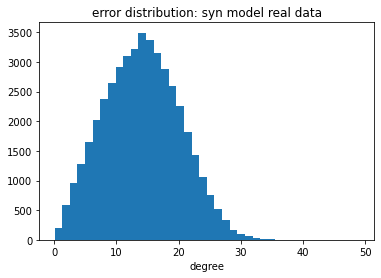

In [21]:
plt.hist(errors, bins=40)
plt.title("error distribution: syn model real data")
plt.xlabel("degree")

In [17]:
mean_error = errors.mean()
print(mean_error)

14.106722314182216


In [18]:
ix = 0
for k, v in images_errors.items():
    if ix >20:
        break
    print(k, v)
    ix += 1

p10/face/2584.jpg 48.97344562592427
p08/face/1749.jpg 41.55213714349922
p08/face/2264.jpg 41.282525148702625
p10/face/1733.jpg 40.923377060470294
p10/face/2683.jpg 40.3679560744306
p05/face/2073.jpg 38.71083030264406
p10/face/1776.jpg 38.25028925047584
p07/face/2181.jpg 37.71612064676238
p02/face/1384.jpg 37.6712621623118
p08/face/1839.jpg 36.932030065207414
p03/face/911.jpg 36.91308960073547
p03/face/93.jpg 36.43789330804177
p10/face/1064.jpg 36.08756394846143
p06/face/1792.jpg 36.01722732785607
p07/face/2424.jpg 35.80745247292433
p08/face/554.jpg 35.59480946566982
p04/face/2969.jpg 35.50168276071368
p08/face/1843.jpg 35.49906712767133
p08/face/1637.jpg 35.094083237602945
p04/face/2482.jpg 34.9995377208971
p08/face/1882.jpg 34.95584291307669


In [22]:
len(images_errors)

45000

In [23]:
ix = 0
for k, v in images_errors.items():
    if ix >20:
        break
    print(k, v)
    ix += 1

p10/face/2584.jpg 48.97344562592427
p08/face/1749.jpg 41.55213714349922
p08/face/2264.jpg 41.282525148702625
p10/face/1733.jpg 40.923377060470294
p10/face/2683.jpg 40.3679560744306
p05/face/2073.jpg 38.71083030264406
p10/face/1776.jpg 38.25028925047584
p07/face/2181.jpg 37.71612064676238
p02/face/1384.jpg 37.6712621623118
p08/face/1839.jpg 36.932030065207414
p03/face/911.jpg 36.91308960073547
p03/face/93.jpg 36.43789330804177
p10/face/1064.jpg 36.08756394846143
p06/face/1792.jpg 36.01722732785607
p07/face/2424.jpg 35.80745247292433
p08/face/554.jpg 35.59480946566982
p04/face/2969.jpg 35.50168276071368
p08/face/1843.jpg 35.49906712767133
p08/face/1637.jpg 35.094083237602945
p04/face/2482.jpg 34.9995377208971
p08/face/1882.jpg 34.95584291307669


In [26]:
ix = 0
for k, v in images_errors.items():
    ix += 1
    if ix <44980:
        continue
    print(k, v)
    

p03/face/495.jpg 0.4140718492294549
p13/face/711.jpg 0.4103402850581999
p13/face/2623.jpg 0.4023572317430559
p14/face/2583.jpg 0.3984362865547407
p07/face/1502.jpg 0.39691274795764764
p03/face/2823.jpg 0.3905926890263135
p12/face/1169.jpg 0.3635561994070233
p00/face/1379.jpg 0.3497070933133568
p14/face/648.jpg 0.33795465326370144
p00/face/2698.jpg 0.3210336157079494
p02/face/849.jpg 0.3191513647263278
p06/face/1319.jpg 0.3188226212047413
p09/face/2701.jpg 0.27614662709741866
p10/face/1394.jpg 0.25930844905319345
p10/face/1205.jpg 0.24080743758116976
p07/face/2542.jpg 0.15721851442286455
p05/face/883.jpg 0.15147917848628337
p06/face/1771.jpg 0.1480399607113712
p00/face/150.jpg 0.1312691368755004
p12/face/668.jpg 0.11127899985979915
p02/face/2050.jpg 0.07329438786876252


In [27]:
ix = 0
for k, v in images_errors.items():
    ix += 1
    if ix <22480 or ix >22500:
        continue
    print(k, v)

p04/face/1193.jpg 14.08724462916532
p01/face/530.jpg 14.086394733282408
p03/face/2270.jpg 14.085951417698213
p10/face/1396.jpg 14.085055660319535
p14/face/1431.jpg 14.084846335711944
p03/face/1549.jpg 14.08482724414551
p09/face/989.jpg 14.084373943818264
p09/face/1088.jpg 14.08421368526111
p05/face/1383.jpg 14.083858016583047
p11/face/292.jpg 14.083567054233383
p14/face/861.jpg 14.083079985953518
p02/face/872.jpg 14.081976879563333
p09/face/275.jpg 14.081453302449894
p10/face/1307.jpg 14.081335849066832
p06/face/69.jpg 14.081314339458558
p14/face/2991.jpg 14.080152495309724
p11/face/769.jpg 14.079666513896832
p01/face/2373.jpg 14.079624384157766
p08/face/2293.jpg 14.079370709443582
p11/face/728.jpg 14.079369249195265
p07/face/2847.jpg 14.079304551506421
